### Dimensionality Reduction Review
##### 12Dec18
Using proportional downsampling techniques, get subsets of discrete and continous data to feature-select prior to running DR algorithms for comparison on relatively low-dimensional raw data.

In [7]:
from fcc_DRs import *
from fcc_utils import *

Using TensorFlow backend.


In [11]:
from scvi.dataset import CsvDataset
import urllib

In [66]:
# Loading a local dataset into scVI
colon1_scVI = CsvDataset('GSM2743164_rep1_colon_rnaseq.csv.gz', 
                               save_path='inputs/', 
                               compression='gzip') 

File inputs/GSM2743164_rep1_colon_rnaseq.csv.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 25504 to 600 genes
Downsampling from 1738 to 1738 cells


#### Training scVI
* __n_epochs__: Maximum number of epochs to train the model. If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 
* __use_batches__: If the value of true than batch information is used in the training. Here it is set to false because the data only contains one batch. 
* __use_cuda__: Set to true to use CUDA. 


In [22]:
from scvi.models import *
from scvi.inference import UnsupervisedTrainer
n_epochs=400 
lr=1e-3
use_batches=False
use_cuda=True

%matplotlib inline

**Train the model and output model likelihood every 5 epochs**

In [20]:
vae = VAE(colon1_scVI.nb_genes, n_batch=colon1_scVI.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              colon1_scVI,
                              train_size=0.75,
                              use_cuda=use_cuda,
                              frequency=5)
trainer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████████████████████████████████████████████████████████████████████████████| 400/400 [02:21<00:00,  2.65it/s]


**Plotting the likelihood change across the 500 epochs of training: blue for training error and orange for testing error.**

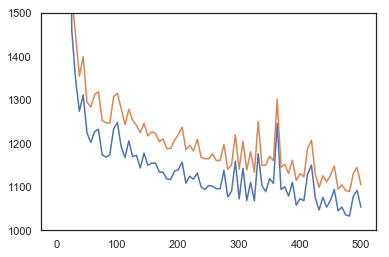

In [27]:
ll_train_set = trainer.history["ll_train_set"]
ll_test_set = trainer.history["ll_test_set"]
x = np.linspace(0,500,(len(ll_train_set)))
plt.plot(x, ll_train_set)
plt.plot(x, ll_test_set)
plt.ylim(1000,1500)
plt.show()

In [39]:
type(trainer.test_set).__name__

'Posterior'

In [62]:
trainer.train_set.raw_data()[0] # I think this is the counts? At least for the training set.

array([[192.,  70.,   0., ...,   5.,   4.,   5.],
       [615., 348., 161., ...,   4.,   4.,   3.],
       [370., 118.,  30., ...,   3.,   1.,   2.],
       ...,
       [ 18.,  13.,   2., ...,   1.,   0.,   1.],
       [  4., 335.,   3., ...,   0.,   2.,   1.],
       [  3.,   0.,   1., ...,   0.,   0.,   2.]], dtype=float32)

In [68]:
colon1_scVI_preprocessed = RNA_counts(data=colon1_scVI.X.astype('double'), labels=[None,None])

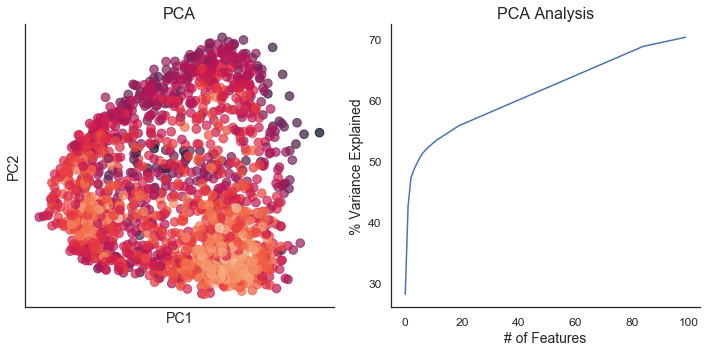

In [71]:
colon1_scVI_PCA = fcc_PCA(colon1_scVI_preprocessed.arcsinh_norm(), n_components=100)
colon1_scVI_PCA.plot()

In [72]:
%%time
colon1_scVI_tSNE = fcc_tSNE(colon1_scVI_PCA.results, perplexity=30)
colon1_scVI_tSNE.plot()

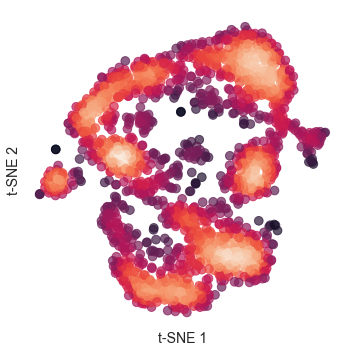

In [73]:
colon1_scVI_tSNE.plot()

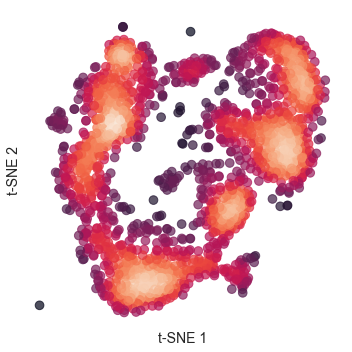

CPU times: user 13.4 s, sys: 440 ms, total: 13.8 s
Wall time: 13.8 s


In [74]:
%%time
colon1_scVI_tSNE = fcc_tSNE(colon1_scVI_preprocessed.arcsinh_norm(), perplexity=30)
colon1_scVI_tSNE.plot()

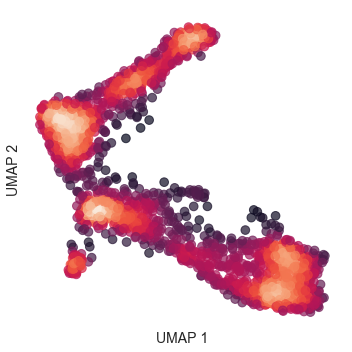

CPU times: user 10.3 s, sys: 586 ms, total: 10.9 s
Wall time: 11.1 s


In [75]:
%%time
colon1_scVI_UMAP = fcc_UMAP(colon1_scVI_preprocessed.arcsinh_norm(), perplexity=30)
colon1_scVI_UMAP.plot()

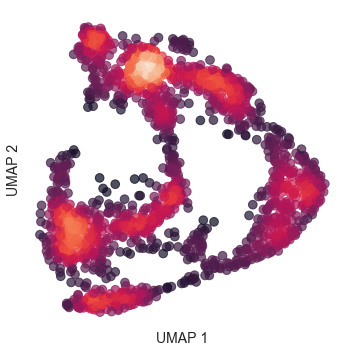

CPU times: user 4.58 s, sys: 255 ms, total: 4.83 s
Wall time: 4.59 s


In [76]:
%%time
colon1_scVI_UMAP = fcc_UMAP(colon1_scVI_PCA.results, perplexity=30)
colon1_scVI_UMAP.plot()

See how this is different (if at all) from variance feature selection to 600 genes.  
That might be all that this did...

In [79]:
colon1 = RNA_counts.from_file('inputs/GSM2743164_rep1_colon_rnaseq.csv.gz', cells_axis=1)

In [83]:
colon1_600genes = RNA_counts.var_select(counts_obj=colon1, n_features=600)

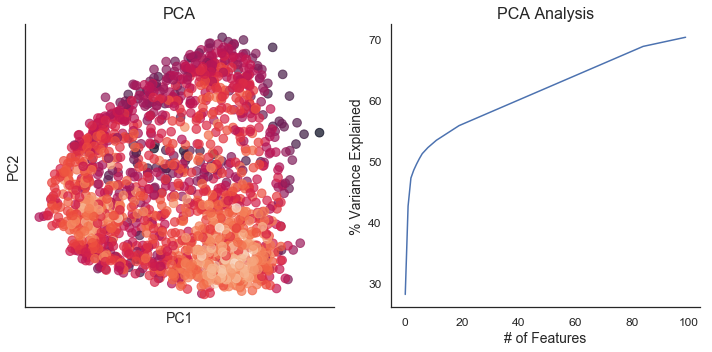

CPU times: user 1.34 s, sys: 135 ms, total: 1.48 s
Wall time: 929 ms


In [84]:
%%time
colon1_600genes_PCA = fcc_PCA(colon1_600genes.arcsinh_norm(), n_components=100)
colon1_600genes_PCA.plot()

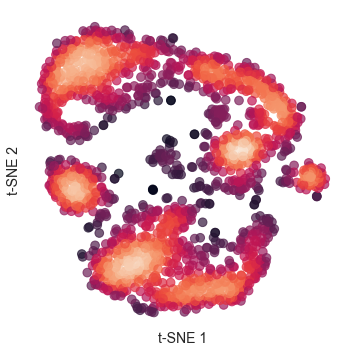

CPU times: user 10.6 s, sys: 415 ms, total: 11 s
Wall time: 10.9 s


In [85]:
%%time
colon1_600genes_tSNE = fcc_tSNE(colon1_600genes_PCA.results, perplexity=30)
colon1_600genes_tSNE.plot()

Okay, these are the same, so scVI just downsampled based on variable genes...

In [86]:
colon1_scVI.X.astype('double')

array([[1.377e+03, 4.220e+02, 6.530e+02, ..., 2.000e+00, 1.000e+00,
        1.000e+00],
       [9.000e+00, 3.000e+00, 2.000e+00, ..., 6.000e+00, 7.000e+00,
        6.000e+00],
       [1.800e+01, 1.000e+01, 5.000e+00, ..., 4.000e+00, 3.000e+00,
        8.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.200e+01, 2.000e+00, 0.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [8.000e+00, 1.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [87]:
colon1_600genes.counts

array([[1377,  422,  653, ...,    2,    1,    1],
       [   9,    3,    2, ...,    6,    7,    6],
       [  18,   10,    5, ...,    4,    3,    8],
       ...,
       [   0,    0,    0, ...,    1,    0,    0],
       [  12,    2,    0, ...,    1,    0,    0],
       [   8,    1,    0, ...,    0,    0,    0]])

yep.  
  
---

In [62]:
trainer.train_set.raw_data()[0] # I think this is the counts? At least for the training set.

array([[192.,  70.,   0., ...,   5.,   4.,   5.],
       [615., 348., 161., ...,   4.,   4.,   3.],
       [370., 118.,  30., ...,   3.,   1.,   2.],
       ...,
       [ 18.,  13.,   2., ...,   1.,   0.,   1.],
       [  4., 335.,   3., ...,   0.,   2.,   1.],
       [  3.,   0.,   1., ...,   0.,   0.,   2.]], dtype=float32)

In [88]:
colon1_scVI_preprocessed = RNA_counts(data=trainer.train_set.raw_data()[0].astype('double'), labels=[None,None])

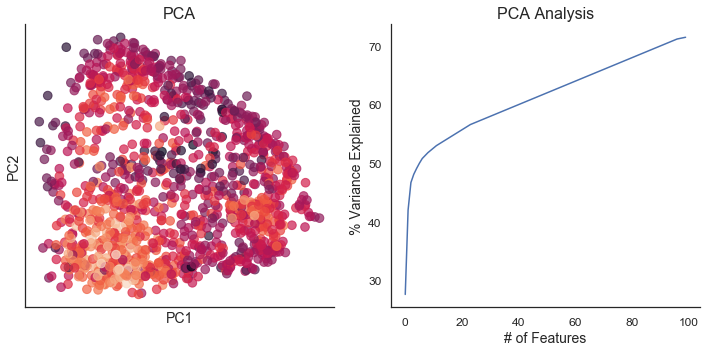

In [89]:
colon1_scVI_PCA = fcc_PCA(colon1_scVI_preprocessed.arcsinh_norm(), n_components=100)
colon1_scVI_PCA.plot()

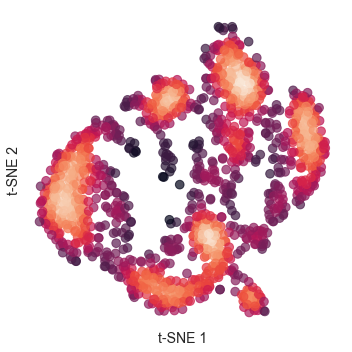

CPU times: user 8.19 s, sys: 351 ms, total: 8.54 s
Wall time: 8.47 s


In [90]:
%%time
colon1_scVI_tSNE = fcc_tSNE(colon1_scVI_PCA.results, perplexity=30)
colon1_scVI_tSNE.plot()

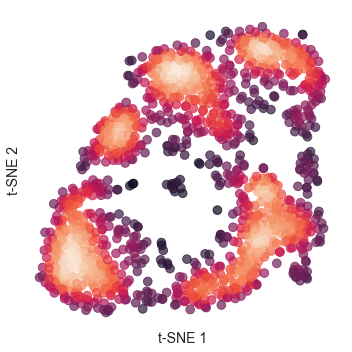

CPU times: user 9.4 s, sys: 385 ms, total: 9.78 s
Wall time: 9.69 s


In [91]:
%%time
colon1_scVI_tSNE = fcc_tSNE(colon1_scVI_preprocessed.arcsinh_norm(), perplexity=30)
colon1_scVI_tSNE.plot()

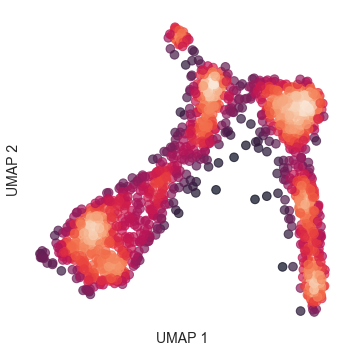

CPU times: user 3.91 s, sys: 195 ms, total: 4.1 s
Wall time: 3.87 s


In [92]:
%%time
colon1_scVI_UMAP = fcc_UMAP(colon1_scVI_preprocessed.arcsinh_norm(), perplexity=30)
colon1_scVI_UMAP.plot()

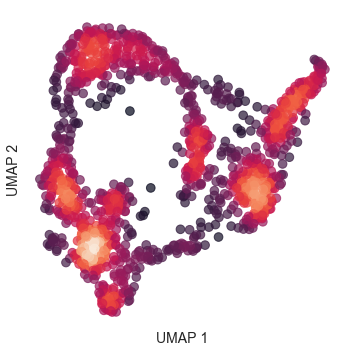

CPU times: user 3.32 s, sys: 232 ms, total: 3.55 s
Wall time: 3.3 s


In [93]:
%%time
colon1_scVI_UMAP = fcc_UMAP(colon1_scVI_PCA.results, perplexity=30)
colon1_scVI_UMAP.plot()

In [102]:
test1 = RNA_counts.from_file('inputs/GSM1626793_P14Retina_1.digital_expression.txt.gz', cells_axis=1)
test1.data

gene,10:100015630-100100413:Kitl,10:100443902-100487350:Tmtc3,10:100488289-100573655:Cep290,10:100572274-100589259:4930430F08Rik,10:100592386-100618391:1700017N19Rik,10:101681487-102391469:Mgat4c,10:102512222-102546560:Rassf9,10:103063198-103236322:Lrriq1,10:10335703-10472326:Adgb,10:103367808-103419378:Slc6a15,...,X:99136130-99148991:Efnb1,X:99465734-99471273:Pja1,X:99821021-99848790:Tmem28,X:99975606-100400762:Eda,Y:1010543-1028847:Eif2s3y,Y:10640942-10643315:Gm20775,Y:1096861-1245759:Uty,Y:1260715-1286613:Ddx3y,Y:897788-943811:Kdm5d,Y:991630-991748:n-R5s1
GGCCGCAGTCCG,0,3,1,2,0,0,0,0,0,4,...,0,8,1,0,0,0,0,0,0,0
CTTGTGCGGGAA,0,0,3,1,0,0,0,0,0,1,...,0,9,0,0,2,0,1,5,0,0
GCGCAACTGCTC,1,0,0,2,0,4,0,0,0,3,...,1,11,0,0,0,0,0,0,0,0
GATTGGGAGGCA,0,0,2,0,0,1,0,0,0,2,...,1,2,0,0,3,0,1,0,0,0
CCTCCTAGTTGG,0,2,1,1,0,2,0,0,0,1,...,0,3,0,0,0,0,0,0,0,0
AGTCAAGCCCTC,0,0,18,1,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
GTGCCGCCTCTC,0,1,10,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,2,0
CCTGTGACACAC,1,1,3,1,0,0,0,0,0,0,...,0,6,0,0,0,0,0,0,0,0
AATCTCGTTAAT,0,0,4,1,0,0,0,0,0,0,...,0,7,0,0,0,0,0,0,0,0
GATTTCCTCTGA,0,0,3,1,0,0,0,0,0,0,...,0,5,0,0,0,0,0,0,0,0


In [101]:
test = RNA_counts.from_file('inputs/GSM1626793_P14Retina_1.digital_expression.txt.gz')
test.data

,GGCCGCAGTCCG,CTTGTGCGGGAA,GCGCAACTGCTC,GATTGGGAGGCA,CCTCCTAGTTGG,AGTCAAGCCCTC,GTGCCGCCTCTC,CCTGTGACACAC,AATCTCGTTAAT,GATTTCCTCTGA,...,GATTTAATGGTA,TGTAAGGATCCG,GAGTGGCTTGAT,GCATCTTTCAGG,ACACGAGTTTGG,CACCCAGTTTCG,CCTGGAGAGTTT,TCTTCACTCTTA,GCCGTCTTACTA,GACCAAACTAAT
gene,,,,,,,,,,,,,,,,,,,,,
10:100015630-100100413:Kitl,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10:100443902-100487350:Tmtc3,3,0,0,0,2,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10:100488289-100573655:Cep290,1,3,0,2,1,18,10,3,4,3,...,4,0,3,0,0,0,0,2,0,1
10:100572274-100589259:4930430F08Rik,2,1,2,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
10:100592386-100618391:1700017N19Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10:101681487-102391469:Mgat4c,0,0,4,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10:102512222-102546560:Rassf9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10:103063198-103236322:Lrriq1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10:10335703-10472326:Adgb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
